# NMPC Controller Analysis

This notebook analyzes all trajectory tracking results for the **NMPC (Acados)** controller.

**Contents:**
1. RMSE table for every trajectory
2. Standard trajectories vs references (Circle A/B, Lemniscate A/B, Sawtooth, Triangle)
3. Spinning circle and helix trajectories with specialized views (x vs y, z vs time, yaw vs time)
4. Helix trajectories in 3D

## 1. Imports and Configuration

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import importlib, sys
if 'utilities' in sys.modules:
    importlib.reload(sys.modules['utilities'])

from utilities import (
    load_csv,
    detect_trajectory_plane,
    plot_trajectory_2d,
    calculate_position_rmse,
    calculate_overall_rmse,
    calculate_rmse_per_axis,
    align_reference_to_actual,
    get_flat_output_and_desired,
)

plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

In [2]:
# ===== CONFIGURATION =====
CONTROLLER_NAME = 'NMPC'
DATA_DIR = Path('log_files/nmpc_acados_euler_err/')
FILE_PREFIX = 'hw_nmpc_acados_euler_err_'

# Trajectory suffix -> (display name, category)
TRAJECTORY_INFO = {
    'circle_horz_2x':      ('Circle A',        'standard'),
    'circle_vert_2x':      ('Circle B',        'standard'),
    'fig8_horz_2x':        ('Lemniscate A',    'standard'),
    'fig8_vert_2x_short':  ('Lemniscate B',    'standard'),
    'fig8_vert_2x':        ('Lemniscate C',    'standard'),
    'sawtooth_2x':         ('Sawtooth',        'standard'),
    'triangle_2x':         ('Triangle',        'standard'),
    'circle_horz_2x_spin': ('Spinning Circle', 'spin_circle'),
    'helix_2x':            ('Helix',           'helix'),
    'helix_2x_spin':       ('Spinning Helix',  'helix_spin'),
}

STANDARD_ORDER = [
    'circle_horz_2x', 'circle_vert_2x', 'fig8_horz_2x',
    'fig8_vert_2x_short', 'fig8_vert_2x', 'sawtooth_2x', 'triangle_2x'
]
SPECIAL_ORDER = ['circle_horz_2x_spin', 'helix_2x', 'helix_2x_spin']

output_dir = Path('output/')
output_dir.mkdir(exist_ok=True)

## 2. Load Data

In [3]:
datasets = {}
for csv_file in sorted(DATA_DIR.glob('*.csv')):
    stem = csv_file.stem
    traj_suffix = stem[len(FILE_PREFIX):]

    if traj_suffix not in TRAJECTORY_INFO:
        print(f"Warning: Unknown trajectory '{traj_suffix}' in {csv_file.name}")
        continue

    display_name, category = TRAJECTORY_INFO[traj_suffix]
    df = load_csv(str(csv_file))

    # Rename comptime -> comp_time for compatibility with utilities
    if 'comptime' in df.columns and 'comp_time' not in df.columns:
        df = df.rename(columns={'comptime': 'comp_time'})

    datasets[traj_suffix] = {
        'df': df,
        'name': display_name,
        'category': category,
        'filename': csv_file.name,
    }

print(f"Loaded {len(datasets)} trajectories for {CONTROLLER_NAME}:\n")
for suffix in STANDARD_ORDER + SPECIAL_ORDER:
    if suffix in datasets:
        info = datasets[suffix]
        print(f"  {info['name']:20s} [{info['category']:12s}]  <- {info['filename']}")

Loaded 9 trajectories for NMPC:

  Circle A             [standard    ]  <- hw_nmpc_acados_euler_err_circle_horz_2x.csv
  Circle B             [standard    ]  <- hw_nmpc_acados_euler_err_circle_vert_2x.csv
  Lemniscate A         [standard    ]  <- hw_nmpc_acados_euler_err_fig8_horz_2x.csv
  Lemniscate B         [standard    ]  <- hw_nmpc_acados_euler_err_fig8_vert_2x_short.csv
  Sawtooth             [standard    ]  <- hw_nmpc_acados_euler_err_sawtooth_2x.csv
  Triangle             [standard    ]  <- hw_nmpc_acados_euler_err_triangle_2x.csv
  Spinning Circle      [spin_circle ]  <- hw_nmpc_acados_euler_err_circle_horz_2x_spin.csv
  Helix                [helix       ]  <- hw_nmpc_acados_euler_err_helix_2x.csv
  Spinning Helix       [helix_spin  ]  <- hw_nmpc_acados_euler_err_helix_2x_spin.csv


## 3. RMSE Table

In [4]:
rows = []
for suffix in STANDARD_ORDER + SPECIAL_ORDER:
    if suffix not in datasets:
        continue
    info = datasets[suffix]
    df = info['df']

    pos_rmse = calculate_position_rmse(df, flip_z=True, align_lookahead=True)
    per_axis = calculate_rmse_per_axis(df, flip_z=True, align_lookahead=True)
    comp_time = df['comp_time'].mean() * 1000 if 'comp_time' in df.columns else None

    rows.append({
        'Trajectory': info['name'],
        'Pos. RMSE [m]': round(pos_rmse, 4),
        'X RMSE [m]': round(per_axis['x'], 4),
        'Y RMSE [m]': round(per_axis['y'], 4),
        'Z RMSE [m]': round(per_axis['z'], 4),
        'Yaw RMSE [rad]': round(per_axis['yaw'], 4),
        'Comp. Time [ms]': round(comp_time, 2) if comp_time else 'N/A',
    })

rmse_table = pd.DataFrame(rows)
print(f"RMSE Table — {CONTROLLER_NAME}")
print("=" * 95)
display(rmse_table)

RMSE Table — NMPC


,Trajectory,Pos. RMSE [m],X RMSE [m],Y RMSE [m],Z RMSE [m],Yaw RMSE [rad],Comp. Time [ms]
0,Circle A,0.1973,0.1669,0.0452,0.0949,0.0199,13.04
1,Circle B,0.2528,0.1441,0.0363,0.2045,0.0186,13.37
2,Lemniscate A,0.3019,0.1666,0.0358,0.2493,0.0154,13.09
3,Lemniscate B,0.1872,0.1493,0.0271,0.1097,0.0213,13.31
4,Sawtooth,0.2491,0.1307,0.0224,0.2108,0.0205,13.33
5,Triangle,0.1160,0.0698,0.0540,0.0752,0.0147,13.19
6,Spinning Circle,0.2348,0.1260,0.1078,0.1663,0.0174,13.71
7,Helix,0.2789,0.1731,0.1138,0.1868,0.0230,13.32
8,Spinning Helix,0.1988,0.1166,0.1170,0.1106,0.0238,13.30


## 4. Standard Trajectories vs References

All trajectories except spinning circle and helix variants, plotted in their auto-detected 2D plane.

**Note:** NMPC does not have Lemniscate C (fig8 vertical tall) data.

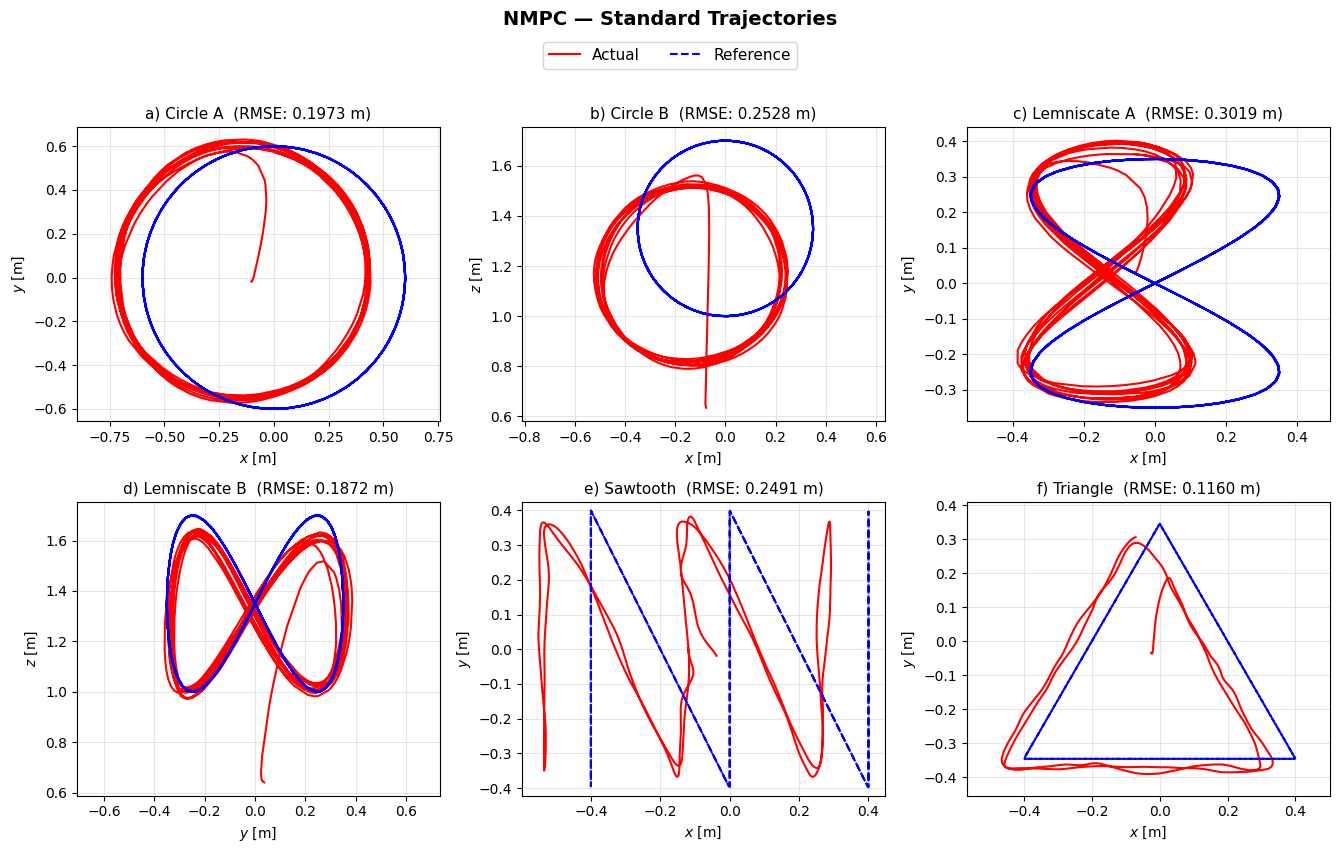

In [5]:
std_keys = [k for k in STANDARD_ORDER if k in datasets]
n = len(std_keys)
n_cols = 3 if n <= 6 else 4
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 4 * n_rows))
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes[np.newaxis, :]
axes_flat = axes.flatten()

for idx, suffix in enumerate(std_keys):
    ax = axes_flat[idx]
    info = datasets[suffix]
    df = info['df'].copy()

    # NED -> ENU
    df['z'] = -df['z']
    df['z_ref'] = -df['z_ref']
    df = align_reference_to_actual(df, sampling_rate=10.0)

    plane = detect_trajectory_plane(df)
    plot_trajectory_2d(ax, df, plane=plane, flip_z=False, align_lookahead=False)

    rmse = calculate_position_rmse(df, flip_z=False, align_lookahead=False)
    label = chr(ord('a') + idx)
    ax.set_title(f"{label}) {info['name']}  (RMSE: {rmse:.4f} m)", fontsize=11)

    leg = ax.get_legend()
    if leg:
        leg.remove()

for idx in range(n, len(axes_flat)):
    axes_flat[idx].set_visible(False)

# Shared legend
handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2,
           bbox_to_anchor=(0.5, 1.03), fontsize=11)

fig.suptitle(f'{CONTROLLER_NAME} \u2014 Standard Trajectories',
             fontsize=14, fontweight='bold', y=1.06)
plt.tight_layout()
plt.savefig(output_dir / f'{CONTROLLER_NAME.lower().replace(" ", "_")}_standard_trajectories.pdf',
            bbox_inches='tight', dpi=300)
plt.show()

## 5. Spinning Circle and Helix Trajectories

Each row is a special trajectory. Columns show:
- **x vs y**: position tracking in the horizontal plane
- **z vs time**: altitude profile
- **yaw vs time**: heading profile

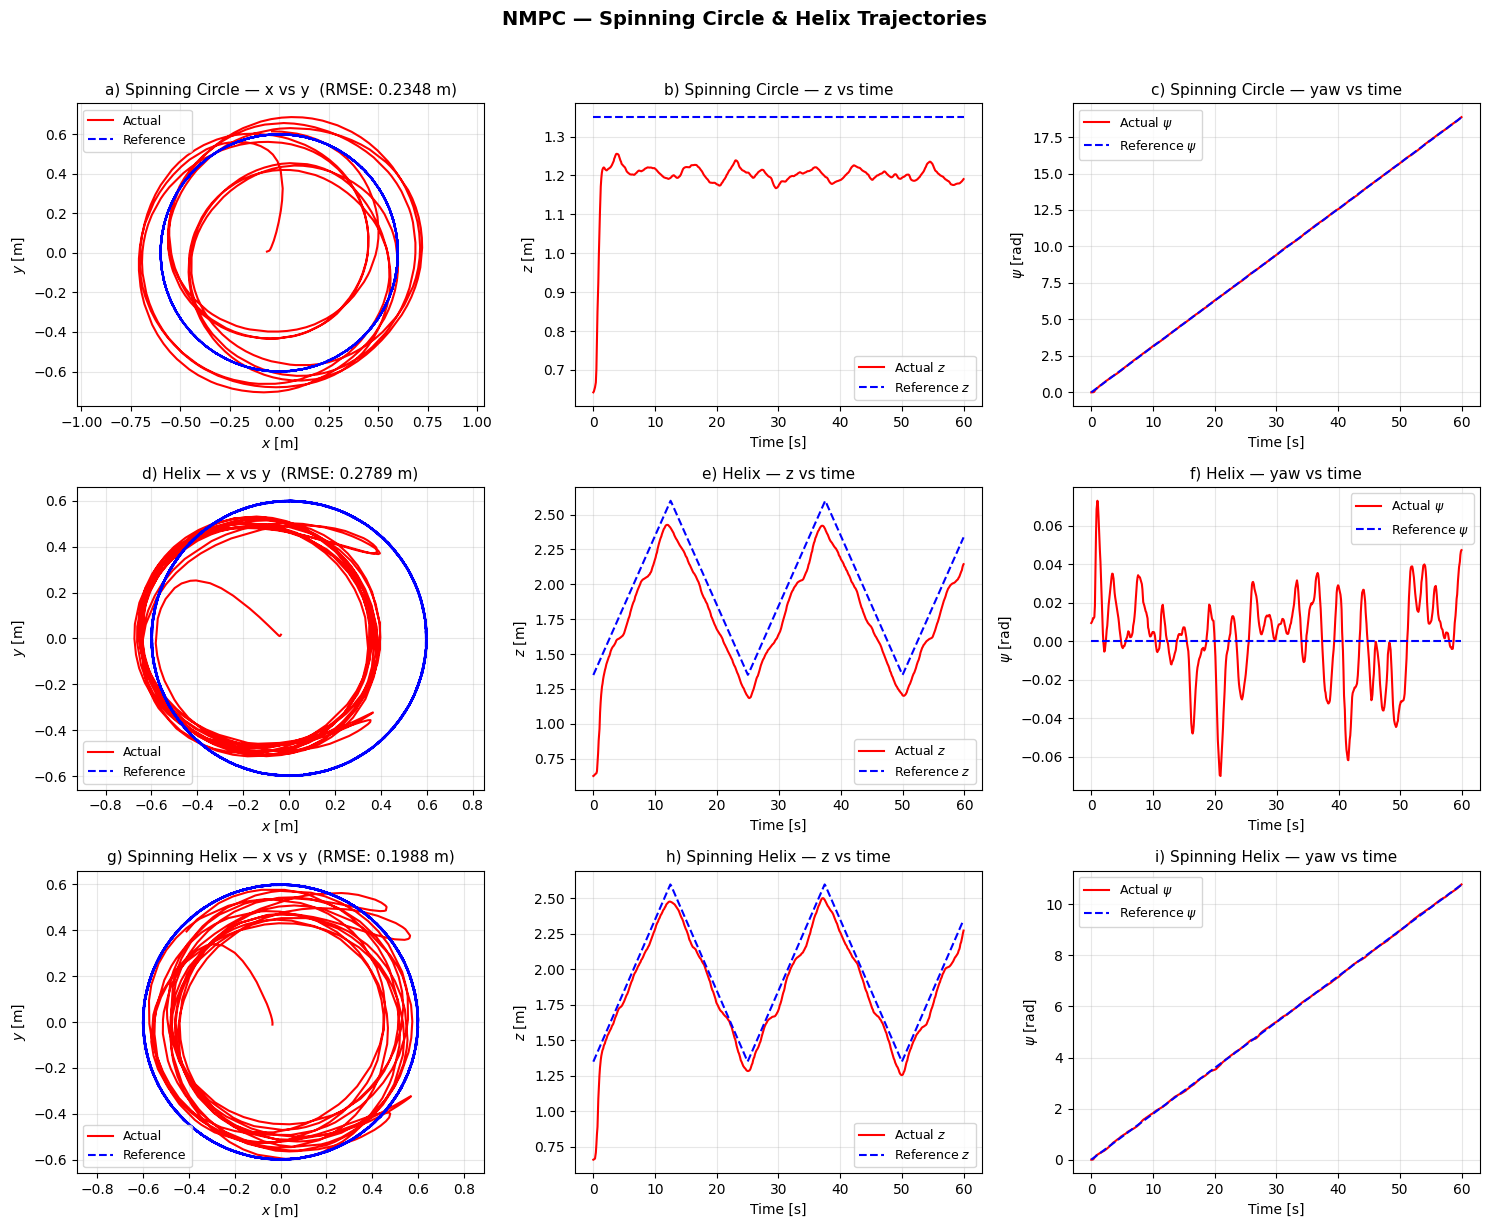

In [6]:
special_keys = [k for k in SPECIAL_ORDER if k in datasets]
n_special = len(special_keys)

if n_special == 0:
    print("No spinning circle or helix trajectories found.")
else:
    fig, axes = plt.subplots(n_special, 3, figsize=(15, 4 * n_special))
    if n_special == 1:
        axes = axes[np.newaxis, :]

    subplot_idx = 0
    for row, suffix in enumerate(special_keys):
        info = datasets[suffix]
        df = info['df'].copy()

        # NED -> ENU
        df['z'] = -df['z']
        df['z_ref'] = -df['z_ref']
        df = align_reference_to_actual(df, sampling_rate=10.0)

        time = df['traj_time'].values if 'traj_time' in df.columns else df['time'].values
        rmse = calculate_position_rmse(df, flip_z=False, align_lookahead=False)

        # Column 0: x vs y
        ax = axes[row, 0]
        ax.plot(df['x'], df['y'], 'r-', label='Actual', linewidth=1.5)
        ax.plot(df['x_ref'], df['y_ref'], 'b--', label='Reference', linewidth=1.5)
        ax.set_xlabel('$x$ [m]')
        ax.set_ylabel('$y$ [m]')
        ax.set_aspect('equal', adjustable='datalim')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        lbl = chr(ord('a') + subplot_idx); subplot_idx += 1
        ax.set_title(f"{lbl}) {info['name']} \u2014 x vs y  (RMSE: {rmse:.4f} m)", fontsize=11)

        # Column 1: z vs time
        ax = axes[row, 1]
        ax.plot(time, df['z'].values, 'r-', label='Actual $z$', linewidth=1.5)
        ax.plot(time, df['z_ref'].values, 'b--', label='Reference $z$', linewidth=1.5)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('$z$ [m]')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        lbl = chr(ord('a') + subplot_idx); subplot_idx += 1
        ax.set_title(f"{lbl}) {info['name']} \u2014 z vs time", fontsize=11)

        # Column 2: yaw vs time
        ax = axes[row, 2]
        ax.plot(time, df['yaw'].values, 'r-', label='Actual $\\psi$', linewidth=1.5)
        ax.plot(time, df['yaw_ref'].values, 'b--', label='Reference $\\psi$', linewidth=1.5)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('$\\psi$ [rad]')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        lbl = chr(ord('a') + subplot_idx); subplot_idx += 1
        ax.set_title(f"{lbl}) {info['name']} \u2014 yaw vs time", fontsize=11)

    fig.suptitle(f'{CONTROLLER_NAME} \u2014 Spinning Circle & Helix Trajectories',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(output_dir / f'{CONTROLLER_NAME.lower().replace(" ", "_")}_special_trajectories.pdf',
                bbox_inches='tight', dpi=300)
    plt.show()

## 6. Helix Trajectories in 3D

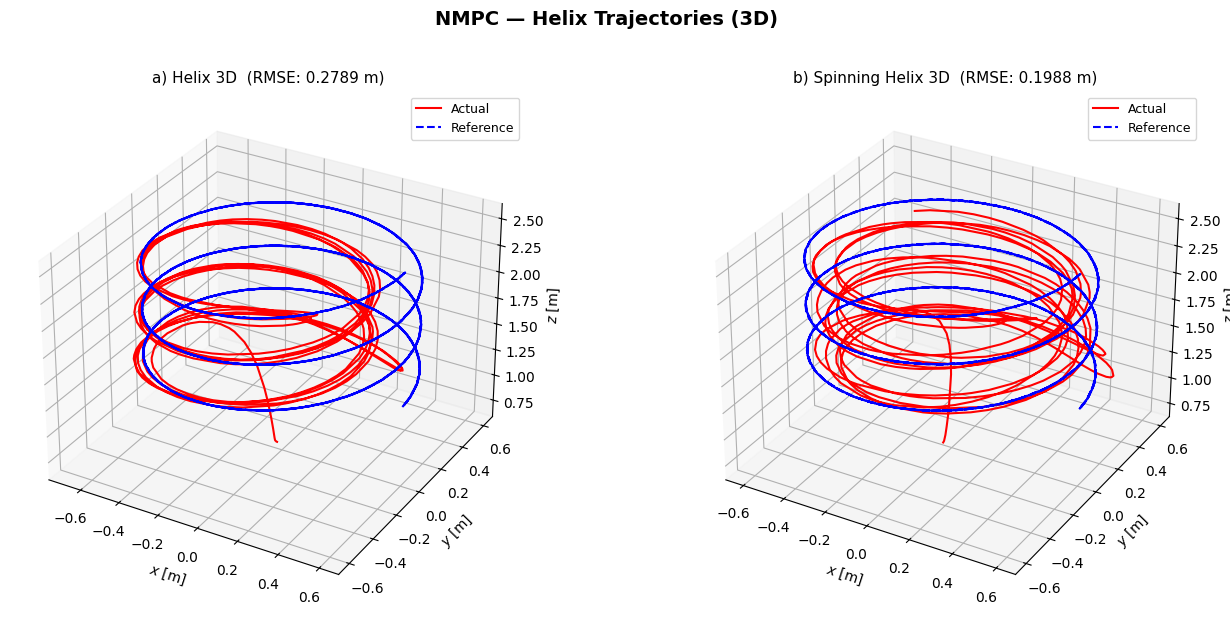

In [7]:
helix_keys = [k for k in ['helix_2x', 'helix_2x_spin'] if k in datasets]
n_helix = len(helix_keys)

if n_helix == 0:
    print("No helix trajectories found.")
else:
    fig = plt.figure(figsize=(7 * n_helix, 6))

    for idx, suffix in enumerate(helix_keys):
        info = datasets[suffix]
        df = info['df'].copy()

        # NED -> ENU
        df['z'] = -df['z']
        df['z_ref'] = -df['z_ref']
        df = align_reference_to_actual(df, sampling_rate=10.0)

        ax = fig.add_subplot(1, n_helix, idx + 1, projection='3d')

        ax.plot(df['x'].values, df['y'].values, df['z'].values,
                'r-', label='Actual', linewidth=1.5)
        ax.plot(df['x_ref'].values, df['y_ref'].values, df['z_ref'].values,
                'b--', label='Reference', linewidth=1.5)

        ax.set_xlabel('$x$ [m]')
        ax.set_ylabel('$y$ [m]')
        ax.set_zlabel('$z$ [m]')
        ax.legend(fontsize=9)

        label = chr(ord('a') + idx)
        rmse = calculate_position_rmse(df, flip_z=False, align_lookahead=False)
        ax.set_title(f"{label}) {info['name']} 3D  (RMSE: {rmse:.4f} m)", fontsize=11)

    fig.suptitle(f'{CONTROLLER_NAME} \u2014 Helix Trajectories (3D)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(output_dir / f'{CONTROLLER_NAME.lower().replace(" ", "_")}_helix_3d.pdf',
                bbox_inches='tight', dpi=300)
    plt.show()